In [1]:
!pip3 install -q tqdm 

In [2]:
!pip3 install -q imgaug

In [3]:
import random
import math
import json
from imgaug import augmenters as iaa
from tqdm import tqdm 
import glob
from google.colab import files
from google.colab import drive
import time
import datetime
from datetime import date
import os, sys, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Install Kaggle API to download competition data
# https://www.kaggle.com/general/74235

!pip3 install -q kaggle

!pip3 install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=9bb380fe3580ab13b78662b96fa090705c279cde67601bf07db6df6561446fc4
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
!ls

sample_data


In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mindyjen","key":"d93d23dee9c18e05d21517d0fadb8efa"}'}

In [7]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-26 21:13:45           6074        553  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3402        292  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1204        105  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [8]:
# enter your Kaggle credentials here
os.environ['KAGGLE_USERNAME']="mindyjen"
os.environ['KAGGLE_KEY']="d93d23dee9c18e05d21517d0fadb8efa"

In [9]:
# directory of the project
drive.mount('/content/gdrive')
!mkdir /content/gdrive/My\ Drive/Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Mounted at /content/gdrive


In [13]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [15]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 62.5MB/s]
100% 2.29G/2.29G [00:20<00:00, 118MB/s] 


In [16]:
!ls

chest-xray-pneumonia.zip


In [ ]:
#!rm -rf chest_xray/

In [ ]:
#!ls

In [ ]:
!unzip \*.zip  && rm *.zip

In [18]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/content/gdrive/My Drive/Kaggle')

In [19]:
os.chdir(ROOT_DIR)
!ls

chest_xray


In [20]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'chest_xray')
os.chdir(MODEL_DIR)
!pwd
!ls

/content/gdrive/My Drive/Kaggle/chest_xray
chest_xray  __MACOSX  test  train  val


In [21]:
# Load the images; be sure to also preprocess these into tensors 
data_viral_dir = os.path.join(MODEL_DIR, 'VIRAL')
data_bacterial_dir = os.path.join(MODEL_DIR, 'BACTERIAL')
data_normal_dir = os.path.join(MODEL_DIR, 'NORMAL')

if not os.path.exists(data_viral_dir):
  os.makedirs(data_viral_dir)

if not os.path.exists(data_bacterial_dir):
  os.makedirs(data_bacterial_dir)

if not os.path.exists(data_normal_dir):
  os.makedirs(data_normal_dir)

!ls

BACTERIAL  chest_xray  __MACOSX  NORMAL  test  train  val  VIRAL


In [22]:
train_dir = os.path.join(MODEL_DIR, 'train')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA')
train_normal = os.path.join(train_dir, 'NORMAL')

test_dir = os.path.join(MODEL_DIR, 'test')
test_pneumonia = os.path.join(test_dir, 'PNEUMONIA')
test_normal = os.path.join(test_dir, 'NORMAL')

val_dir = os.path.join(MODEL_DIR, 'val')
val_pneumonia = os.path.join(val_dir, 'PNEUMONIA')
val_normal = os.path.join(val_dir, 'NORMAL')

In [23]:
imgs_train_pneumonia = [file for file in os.listdir(train_pneumonia) if file.endswith('.jpeg')]
print('There are', len(imgs_train_pneumonia), ' PNEUMONIA images for Training')

imgs_train_vir = [file for file in os.listdir(train_pneumonia) if file.find('virus') >= 0 and file.endswith('.jpeg')]
print('There are', len(imgs_train_vir), ' VIRAL PNEUMONIA images for Training')

imgs_train_bac = [file for file in os.listdir(train_pneumonia) if file.find('bacteria') >= 0 and file.endswith('.jpeg')]
print('There are', len(imgs_train_bac), ' BACTERIAL PNEUMONIA images for Training')


for img in imgs_train_vir:
  shutil.move(os.path.join(train_dir, 'PNEUMONIA/', img), data_viral_dir)

for img in imgs_train_bac:
  shutil.move(os.path.join(train_dir, 'PNEUMONIA/', img), data_bacterial_dir)

There are 3875  PNEUMONIA images for Training
There are 1345  VIRAL PNEUMONIA images for Training
There are 2530  BACTERIAL PNEUMONIA images for Training


In [24]:
imgs_test_pneumonia = [file for file in os.listdir(test_pneumonia) if file.endswith('.jpeg')]
print('There are', len(imgs_test_pneumonia), ' PNEUMONIA images for Testing')

imgs_test_vir = [file for file in os.listdir(test_pneumonia) if file.find('virus') >= 0 and file.endswith('.jpeg')]
print('There are', len(imgs_test_vir), ' VIRAL PNEUMONIA images for Testing')

imgs_test_bac = [file for file in os.listdir(test_pneumonia) if file.find('bacteria') >= 0 and file.endswith('.jpeg')]
print('There are', len(imgs_test_bac), ' BACTERIAL PNEUMONIA images for Testing')


for img in imgs_test_vir:
  shutil.move(os.path.join(test_dir, 'PNEUMONIA/', img), data_viral_dir)

for img in imgs_test_bac:
  shutil.move(os.path.join(test_dir, 'PNEUMONIA/', img), data_bacterial_dir)

There are 390  PNEUMONIA images for Testing
There are 148  VIRAL PNEUMONIA images for Testing
There are 242  BACTERIAL PNEUMONIA images for Testing


In [25]:
imgs_val_pneumonia = [file for file in os.listdir(val_pneumonia) if file.endswith('.jpeg')]
print('There are', len(imgs_val_pneumonia), ' PNEUMONIA images for Validating')

imgs_val_vir = [file for file in os.listdir(val_pneumonia) if file.find('virus') >= 0 and file.endswith('.jpeg')]
print('There are', len(imgs_val_vir), ' VIRAL PNEUMONIA images for Validating')

imgs_val_bac = [file for file in os.listdir(val_pneumonia) if file.find('bacteria') >= 0 and file.endswith('.jpeg')]
print('There are', len(imgs_val_bac), ' BACTERIAL PNEUMONIA images for Validating')


for img in imgs_val_vir:
  shutil.move(os.path.join(val_dir, 'PNEUMONIA/', img), data_viral_dir)

for img in imgs_val_bac:
  shutil.move(os.path.join(val_dir, 'PNEUMONIA/', img), data_bacterial_dir)

There are 8  PNEUMONIA images for Validating
There are 0  VIRAL PNEUMONIA images for Validating
There are 8  BACTERIAL PNEUMONIA images for Validating


In [27]:
imgs_train_nor = [file for file in os.listdir(train_normal) if file.endswith('.jpeg')]
print('There are', len(imgs_train_nor), ' NORMAL images for Training')

imgs_test_nor = [file for file in os.listdir(test_normal) if file.endswith('.jpeg')]
print('There are', len(imgs_test_nor), ' NORMAL images for Testing')

imgs_val_nor = [file for file in os.listdir(val_normal) if file.endswith('.jpeg')]
print('There are', len(imgs_val_nor), ' NORMAL images for Validating')

for img in imgs_train_nor:
  shutil.move(os.path.join(train_dir, 'NORMAL/', img), data_normal_dir)

for img in imgs_test_nor:
  shutil.move(os.path.join(test_dir, 'NORMAL/', img), data_normal_dir)

for img in imgs_val_nor:
  shutil.move(os.path.join(val_dir, 'NORMAL/', img), data_normal_dir)

There are 1288  NORMAL images for Training
There are 234  NORMAL images for Testing
There are 8  NORMAL images for Validating


In [28]:
print(os.listdir(train_pneumonia), os.listdir(test_pneumonia), os.listdir(val_pneumonia))

os.removedirs(train_pneumonia)
os.removedirs(test_pneumonia)
os.removedirs(val_pneumonia)

os.chdir(MODEL_DIR)
!ls

[] [] []
BACTERIAL  chest_xray  __MACOSX  NORMAL  test  train  val  VIRAL


In [29]:
if os.path.isdir(train_dir) == False:
    os.mkdir(train_dir)

if os.path.isdir(test_dir) == False:
    os.mkdir(test_dir)

if os.path.isdir(val_dir) == False:
    os.mkdir(val_dir)

!ls    

BACTERIAL  chest_xray  __MACOSX  NORMAL  test  train  val  VIRAL


In [30]:
!ls ./BACTERIAL/ | head -10

person1000_bacteria_2931.jpeg
person1001_bacteria_2932.jpeg
person1002_bacteria_2933.jpeg
person1003_bacteria_2934.jpeg
person1004_bacteria_2935.jpeg
person1005_bacteria_2936.jpeg
person1006_bacteria_2937.jpeg
person1007_bacteria_2938.jpeg
person1008_bacteria_2939.jpeg
person100_bacteria_475.jpeg


In [31]:
!ls ./VIRAL/ | tail -10

person989_virus_1667.jpeg
person98_virus_182.jpeg
person991_virus_1669.jpeg
person992_virus_1670.jpeg
person993_virus_1671.jpeg
person994_virus_1672.jpeg
person995_virus_1676.jpeg
person996_virus_1677.jpeg
person997_virus_1678.jpeg
person99_virus_183.jpeg


In [32]:
!ls ./NORMAL/ | head -10

IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
IM-0009-0001.jpeg
IM-0010-0001.jpeg
IM-0011-0001-0001.jpeg
IM-0011-0001-0002.jpeg
IM-0011-0001.jpeg


In [33]:
split_ratio = 0.8
classes = ['NORMAL', 'VIRAL', 'BACTERIAL']

for cl in classes:

  img_path = os.path.join(MODEL_DIR, cl)
  images = glob.glob(img_path + '/*.jpeg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*split_ratio))
  num_test = int(round(len(images)*(split_ratio + (1 - split_ratio)*0.5)))
  print('There are ', num_train, ' images for Training and ', num_test - num_train, ' images for Testing and ', len(images) - num_test, ' images for Validating in ', cl)
  train, test, val = images[:num_train], images[num_train:num_test], images[num_test:-1]

  for t1 in train:
    if not os.path.exists(os.path.join(MODEL_DIR, 'train', cl)):
      os.makedirs(os.path.join(MODEL_DIR, 'train', cl))
    shutil.move(t1, os.path.join(MODEL_DIR, 'train', cl))

  for t2 in test:
    if not os.path.exists(os.path.join(MODEL_DIR, 'test', cl)):
      os.makedirs(os.path.join(MODEL_DIR, 'test', cl))  
    shutil.move(t2, os.path.join(MODEL_DIR, 'test', cl))

  for v in val:
    if not os.path.exists(os.path.join(MODEL_DIR, 'val', cl)):
      os.makedirs(os.path.join(MODEL_DIR, 'val', cl))
    shutil.move(v, os.path.join(MODEL_DIR, 'val', cl))

NORMAL: 1583 Images
There are  1266  images for Training and  159  images for Testing and  158  images for Validating in  NORMAL
VIRAL: 1493 Images
There are  1194  images for Training and  150  images for Testing and  149  images for Validating in  VIRAL
BACTERIAL: 2780 Images
There are  2224  images for Training and  278  images for Testing and  278  images for Validating in  BACTERIAL


In [35]:
print(os.listdir(data_viral_dir), os.listdir(data_bacterial_dir), os.listdir(data_normal_dir))

#os.removedirs(data_viral_dir)
#os.removedirs(data_bacterial_dir)
#os.removedirs(data_normal_dir)

os.chdir(MODEL_DIR)
!ls

['person99_virus_183.jpeg'] ['person1954_bacteria_4886.jpeg'] ['NORMAL2-IM-1442-0001.jpeg']
BACTERIAL  chest_xray  __MACOSX  NORMAL  test  train  val  VIRAL


In [75]:
batch_size = 100
IMG_SHAPE = 150 

image_gen = ImageDataGenerator(rescale=1./255)

In [76]:
# get all the data in the directory split/train and reshape them
print('training data:')
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='categorical')

training data:
Found 4684 images belonging to 3 classes.


In [77]:
# get all the data in the directory split/validation and reshape them
print('validating data:')
val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                             directory=val_dir, 
                                             target_size=(IMG_SHAPE, IMG_SHAPE),
                                             class_mode='categorical',
                                             shuffle=False)

validating data:
Found 582 images belonging to 3 classes.


In [54]:
train_data_gen.class_indices

{'BACTERIAL': 0, 'NORMAL': 1, 'VIRAL': 2}

In [79]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation=tf.nn.relu, 
                 input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation=tf.nn.relu))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation=tf.nn.relu))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation=tf.nn.relu))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(512, activation=tf.nn.relu))
model.add(Dense(3, activation=tf.nn.softmax))

In [80]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)     

In [81]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [82]:
epochs = 40

In [83]:
train_data_gen.n

4684

In [84]:
val_data_gen.n

582

In [85]:
print('program starts, current time:')
print(start)
histoire = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2021-05-27 15:27:05.023719
Epoch 1/40
47/47 [==============================] - 282s 5s/step - loss: 1.0383 - accuracy: 0.4831 - val_loss: 0.9870 - val_accuracy: 0.6340
Epoch 2/40
47/47 [==============================] - 229s 5s/step - loss: 0.8762 - accuracy: 0.6181 - val_loss: 0.7302 - val_accuracy: 0.6787
Epoch 3/40
47/47 [==============================] - 226s 5s/step - loss: 0.7572 - accuracy: 0.6597 - val_loss: 0.6835 - val_accuracy: 0.6838
Epoch 4/40
47/47 [==============================] - 225s 5s/step - loss: 0.6947 - accuracy: 0.6842 - val_loss: 0.7209 - val_accuracy: 0.6787
Epoch 5/40
47/47 [==============================] - 226s 5s/step - loss: 0.6501 - accuracy: 0.7118 - val_loss: 0.5991 - val_accuracy: 0.7371
Epoch 6/40
47/47 [==============================] - 225s 5s/step - loss: 0.6245 - accuracy: 0.7263 - val_loss: 0.5869 - val_accuracy: 0.7595
Epoch 7/40
47/47 [==============================] - 223s 5s/step - loss: 0.5869 - accuracy: 0.753

In [86]:
histoire.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [87]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

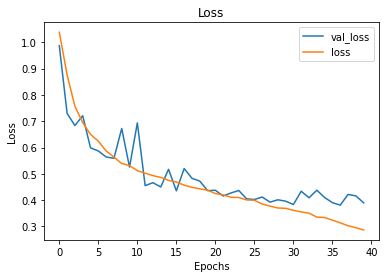

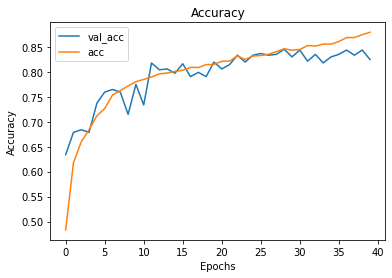

In [88]:
visualize_training_results(histoire)

In [89]:
test_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=test_dir,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              class_mode='categorical',
                                              shuffle=False)

Found 587 images belonging to 3 classes.


In [90]:
test_loss, test_acc = model.evaluate_generator(test_data_gen, steps=int(np.ceil(test_data_gen.n / float(batch_size))))
y_hat_test = model.predict_generator(test_data_gen, steps=int(np.ceil(test_data_gen.n / float(batch_size))))
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

Generated 587 predictions
test acc: 0.8109028935432434
